In [341]:
import pandas as pd
import numpy as np
import dill
#import torch.nn as nn
import torch
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import os
import Graphs
import networkx as nx
#import torch.optim as optim
import random
import copy
import sys
#from torch.nn import functional as F
from collections import defaultdict, Counter
#from torch.utils.data import TensorDataset, DataLoader
#from torch.optim.optimizer import required
#from torchinfo import summary
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import wasserstein_distance, rv_histogram, entropy
from statsmodels.graphics.tsaplots import plot_acf
sns.set_theme(style="whitegrid")

In [3]:
bkdatafolder = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/BKDataCleaned/"

In [277]:
def createDictFloor(floor_idx,path):
    floorname = [f'Floor{idx}' for idx in floor_idx]
    fulldata = os.listdir(path)
    getdict = {}
    floors = [floor for name in floorname for floor in fulldata if name in floor]
    for name in floors:
        floor_zone = name.split(".")[0]
        getdict[floor_zone] = pd.read_csv(path+name, index_col=0, parse_dates=["Date"])
        getdict[floor_zone] = getdict[floor_zone].sort_index()
    return getdict

def Missing_values(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total,percent], axis=1, keys=['Total', 'Pourcentage'])
    print (missing_data[(percent>0)],'\n' )

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
        
def createDTFeat(date1, date2, datadict,featureX,resample_method_X="mean"):
    resample_move = {}
    index_nan = {}
    index_small = {}
    floors = list(datadict.keys())
    dates = []
    scalers = {}
    for floorname in datadict.keys():
        dataX = datadict[floorname][date1:date2][featureX].copy()
        
        if resample_method_X == "sum":
            dataX = dataX.resample("5T").sum()
            
        elif resample_method_X == "mean":
            dataX = dataX.resample("5T").mean().bfill()
        elif resample_method_X == "max":
            dataX = dataX.resample("5T").max().bfill()
        else:
            pass
        
        resample_move[floorname] = pd.concat([dataX],axis=1)
        resample_move[floorname]["date"] = resample_move[floorname].index.date
        resample_move[floorname]["weekday"] = resample_move[floorname].index.weekday
        resample_move[floorname]["date"] = resample_move[floorname]["date"].apply(lambda x: x.strftime("%Y-%m-%d"))
        resample_move[floorname]["time"] = resample_move[floorname].index.time
        resample_move[floorname]["time"] = resample_move[floorname]["time"].apply(lambda x: x.strftime("%H:%M:%S"))
        
        
    for date in resample_move[floors[0]]["date"]:
        dates.append(str(date))
    dates = sorted(set(dates))
            
    return resample_move, dates

def data_scaling(datadict, feature):
    scalers = {}
    scaled_data_dict = copy.deepcopy(datadict)
    for floorname in datadict.keys():
        cols = datadict[floorname][feature].columns
        idx = datadict[floorname][feature].index
        scaler = MinMaxScaler(feature_range=(0,1))
        scaler.fit(scaled_data_dict[floorname][feature])
        scaled_data_dict[floorname][feature] = scaler.transform(scaled_data_dict[floorname][feature])
        scalers[floorname] = scaler
        
        #dummies_floor = pd.get_dummies(scaled_data_dict[floorname]["weekday"])
        #scaled_data_dict[floorname] = pd.concat([scaled_data_dict[floorname],dummies_floor], axis=1)

    return scaled_data_dict, scalers

def get_info_timeshape(datadict):
    for floor in datadict.keys():
        data = datadict[floor]
        print("Floor : {} , shape :{} , TimeMin {} , TimeMax {}".format(floor,data.shape, data.index.min(), data.index.max()))
        Missing_values(data)
        
def cleanNan(data,idx_nan):
    index=[]
    for k,v in idx_nan.items():
        for ele in v:
            index.append(ele)
    mynan = set(index)
    newdata = data.copy()
    remain_date = []
    for floor in idx_nan.keys():
        datafloor = data[floor]
        todropnan = datafloor[datafloor["date"].isin(list(mynan))].index
        datafloor = datafloor.drop(todropnan)
        newdata[floor] = datafloor
        for date in datafloor["date"]:
            remain_date.append(str(date))
    remain_date = sorted(set(remain_date))
    return data, remain_date

In [278]:
def get_info_zone(datadict):
    for data in datadict.keys():
        zone = datadict[data]
        print("{} Start: {} End: {} Count:{}".format(data,zone.index.min(),zone.index.max(), zone.shape[0]))
        print("")

In [335]:
def remove_weekend(datadict):
    mydict = {}
    for floor_zone in datadict.keys():
        mask_sat = datadict[floor_zone].weekday == 5
        mask_sun = datadict[floor_zone].weekday == 6
        index_rmv = datadict[floor_zone].loc[mask_sat | mask_sun].index
        mydict[floor_zone] = datadict[floor_zone].drop(index_rmv,axis=0)
    return mydict

def remove_holidays(datadict, holidays_list):
    mydict = copy.deepcopy(datadict)
    for floor in mydict.keys():
        for date in holidays_list:
            mask_date = mydict[floor].date==date
            index_rmv = mydict[floor].loc[mask_date].index
            mydict[floor] = mydict[floor].drop(index_rmv,axis=0)
    return mydict

def working_hour(datadict,morning,evening):
    mydict = copy.deepcopy(datadict)
    for floor in mydict.keys():
        mask_morning = datadict[floor].time >= morning
        mask_evening = datadict[floor].time <= evening
        mydict[floor] = datadict[floor].loc[mask_morning & mask_evening]
        roll = mydict[floor]["temperature"].rolling(window=7).mean()
        #mydict[floor]["Roll"] = roll
        mydict[floor]["tempdiff"] = mydict[floor]["temperature"].diff()
        mydict[floor]["tempdiff"].fillna(0, inplace=True)
        mydict[floor]["convolve"] = np.convolve(mydict[floor]["tempdiff"],np.ones(5),"same")#np.ones_like(mydict[floor]["tempdiff"]),"same")
        mydict[floor]["Label"] = pd.qcut(mydict[floor]["convolve"],[0,0.25,0.75,1], [2,1,0])
        #mydict[floor]["tempdiff"]
    return mydict

In [348]:
resample_wkh["Floor4Z1"]["convolve"].quantile(0.75)

0.7899999999999991

In [280]:
holidays = ["2019-04-08","2019-04-12","2019-04-13","2019-04-14","2019-04-15","2019-04-16",
           "2019-05-01"]

In [336]:
seed_everything()
date1 = "2019-03-07"
date2 = "2019-09-29"
cutting_date = "2019-04-20"
floors = [4,5,6,7]
floor_dict = createDictFloor(floors, bkdatafolder)
feature = ["ACPower","temperature"]
resample_method = "max"
resample,remain_date = createDTFeat(date1, date2, floor_dict, feature,resample_method_X=resample_method)
#resample_wkh = working_hour(resample, "08:00:00","20:00:00")
resample_wo_holidays = remove_holidays(resample, holidays)
resample_wo_wk = remove_weekend(resample_wo_holidays)
resample_wkh = working_hour(resample_wo_wk, "07:00:00","18:30:00")
scaled_data, scalers = data_scaling(resample_wo_wk, feature)

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/pandas/core/generic.py:6383: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


<AxesSubplot:>

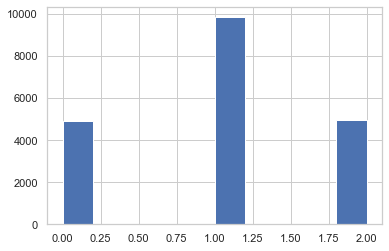

In [345]:
resample_wkh["Floor4Z1"]["Label"].hist()

In [255]:
def change_class(x):
    if (x>=-0.5) & (x<=0.5):
        return 0
    elif x < -0.5:
        return 2
    elif x > 0.5:
        return 1

In [ ]:
def rate_change(data):
    rate = data["convolve"].values
    label = np.empty_like(rate)
    label[0] = 0
    for t in range(1:len(rate)):
        if (rate[t] <= 1) and (rate[t] >= -1):
            label[t] = label[t-1]
        elif (rate[t] <= -1) and label[t-1]==0:
            label[t] = label[t-1] + 2
        elif (rate[t] <= -1) and label

In [259]:
hehe = resample_wkh["Floor4Z1"]["convolve"].apply(change_class)

<AxesSubplot:xlabel='Date'>

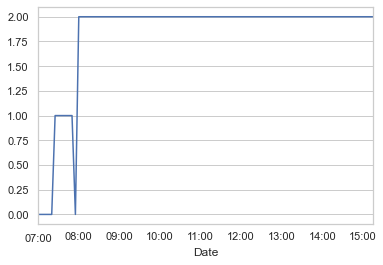

In [260]:
hehe[:100].plot()
#resample_wkh["Floor4Z1"]["ACPower"][:100].plot()

In [334]:
pd.qcut(resample_wkh["Floor4Z1"]["convolve"],[0,0.25,0.75,1], [2,1,0])

Date
2019-03-07 07:00:00    1
2019-03-07 07:05:00    1
2019-03-07 07:10:00    1
2019-03-07 07:15:00    1
2019-03-07 07:20:00    1
                      ..
2019-09-27 18:10:00    1
2019-09-27 18:15:00    1
2019-09-27 18:20:00    1
2019-09-27 18:25:00    1
2019-09-27 18:30:00    1
Name: convolve, Length: 19738, dtype: category
Categories (3, int64): [2 < 1 < 0]

In [212]:
def distribution(datadict, cutting_date,feature):
    zone_list = sorted(list(datadict.keys()))
    concat_feature = pd.DataFrame()
    for zone in zone_list:
        concat_feature = pd.concat([concat_feature, datadict[zone].loc[datadict[zone].date <= cutting_date][feature].rename(f"{zone}")],axis=1)
    return concat_feature

In [342]:
def plot_data(datadict, cutting_date, feature, feature2=None, slc1=None, slc2=None):
    zone_list = sorted(list(datadict.keys()))
    for zone in zone_list:
        print(Counter(datadict[zone]["Label"].values))
        peaks_plus,_ = find_peaks(datadict[zone]["convolve"][slc1:slc2])#, #widths=np.ones(datadict[zone]["convolve"].shape[0])*2)-1
        peaks_minus,_ = find_peaks(-datadict[zone]["convolve"][slc1:slc2])
        #datadict[zone]["convolve"][slc1:slc2].plot(kind="box",figsize=(10,5))
        plt.figure(figsize=(20,5))
        plt.plot(datadict[zone].loc[datadict[zone].date <= cutting_date]["Label"][slc1:slc2].values,label=zone)
        #plt.plot(datadict[zone].loc[datadict[zone].date <= cutting_date]["tempdiff"][slc1:slc2].values,label=zone)
        plt.plot(datadict[zone].loc[datadict[zone].date <= cutting_date]["convolve"][slc1:slc2].values,label=zone)
        #plt.hlines(-1,slc1, slc2)
        #plt.hlines(1,slc1, slc2)
        #plt.plot(peaks, [1 for i in peaks], "x")
        plt.plot(peaks_plus, datadict[zone]["convolve"][peaks_plus],"x")
        plt.plot(peaks_minus, datadict[zone]["convolve"][peaks_minus],"x")
        
        plt.figure(figsize=(20,5))
        plt.plot(datadict[zone].loc[datadict[zone].date <= cutting_date][feature][slc1:slc2].values,label=zone)
        #plt.plot(datadict[zone].loc[datadict[zone].date <= cutting_date]["tempdiff"][slc1:slc2].values,label=zone)
        if feature2 is not None:
            plt.plot(datadict[zone].loc[datadict[zone].date <= cutting_date][feature2][slc1:slc2].values,label=zone)
        plt.legend()
        plt.show()

In [305]:
set_point = {"Floor4Z1":{"Low Power":[0,15],"Mid Power":[15,25],"High Power":[25,60]},
             "Floor4Z2":{"Low Power":[0,10],"Mid Power":[10,20],"High Power":[20,60]},
            "Floor4Z4":{"Low Power":[0,15],"Mid Power":[15,25],"High Power":[25,60]},
            "Floor4Z5":{"Low Power":[0,5],"Mid Power":[5,15],"High Power":[15,60]},
            "Floor5Z2":{"Low Power":[0,10],"Mid Power":[10,20],"High Power":[20,60]},
             "Floor5Z5":{"Low Power":[0,5],"Mid Power":[5,15],"High Power":[15,50]},
            "Floor6Z1":{"Low Power":[0,5],"Mid Power":[5,15],"High Power":[15,60]},
            "Floor6Z2":{"Low Power":[0,10],"Mid Power":[10,20],"High Power":[20,60]},
            "Floor6Z4":{"Low Power":[0,15],"Mid Power":[15,25],"High Power":[25,60]},
            "Floor6Z5":{"Low Power":[0,5],"Mid Power":[5,15],"High Power":[15,60]},
            "Floor7Z1":{"Low Power":[0,10],"Mid Power":[10,20],"High Power":[20,60]},
             "Floor7Z2":{"Low Power":[0,10],"Mid Power":[10,20],"High Power":[20,60]},
            "Floor7Z4":{"Low Power":[0,10],"Mid Power":[10,20],"High Power":[20,60]},
             "Floor7Z5":{"Low Power":[0,5],"Mid Power":[5,15],"High Power":[15,60]}}

In [306]:
from scipy.signal import find_peaks, find_peaks_cwt

In [152]:
slc = 300
floor = "Floor5Z1"
data1 = pd.Series(resample_wkh[floor]["temperature"][:slc])
data2 = pd.Series(resample_wkh[floor]["Roll"][:slc])

In [153]:
peaks, _ = find_peaks(data1)
peaksac,_ = find_peaks(data2)

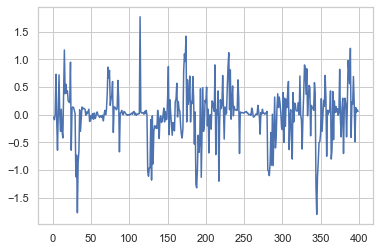

In [168]:
plt.plot(resample_wkh["Floor4Z1"]["temperature"][200:600].diff().values)

Counter({1: 9846, 2: 4960, 0: 4932})


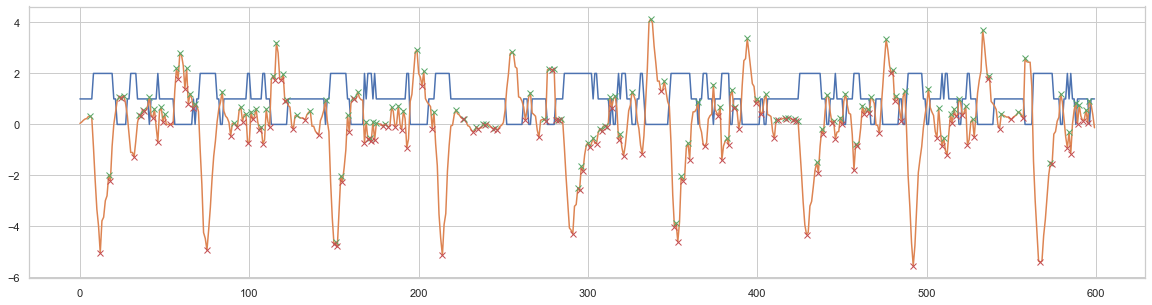

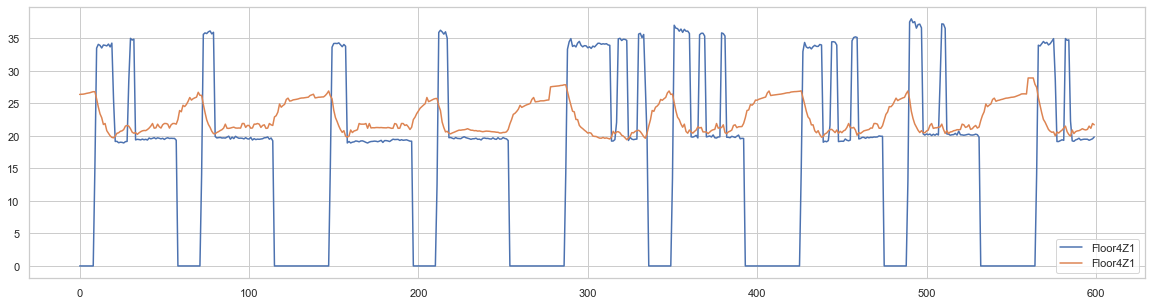

Counter({1: 9853, 2: 4960, 0: 4925})


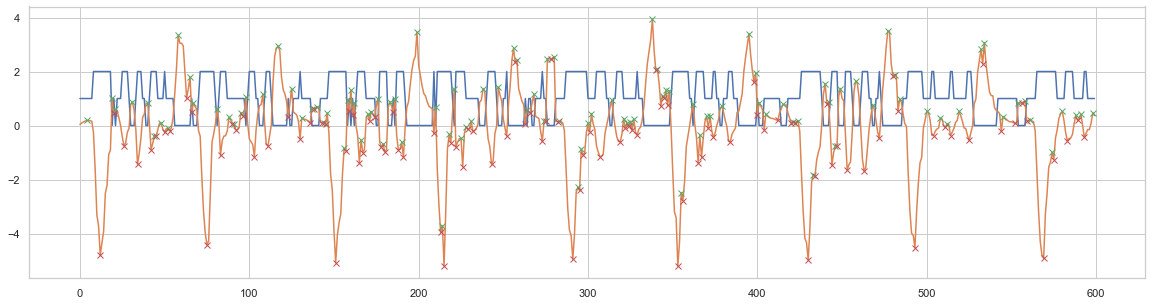

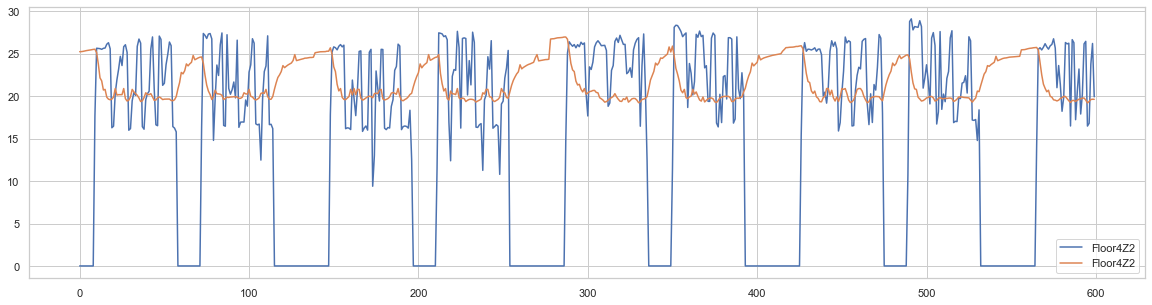

Counter({1: 9800, 2: 5009, 0: 4929})


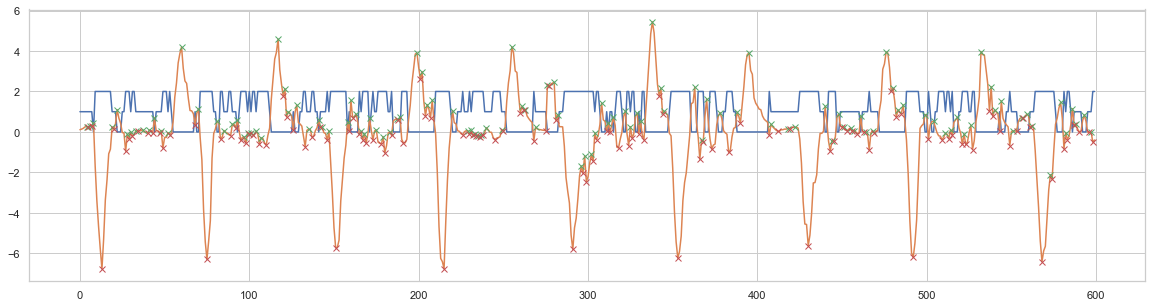

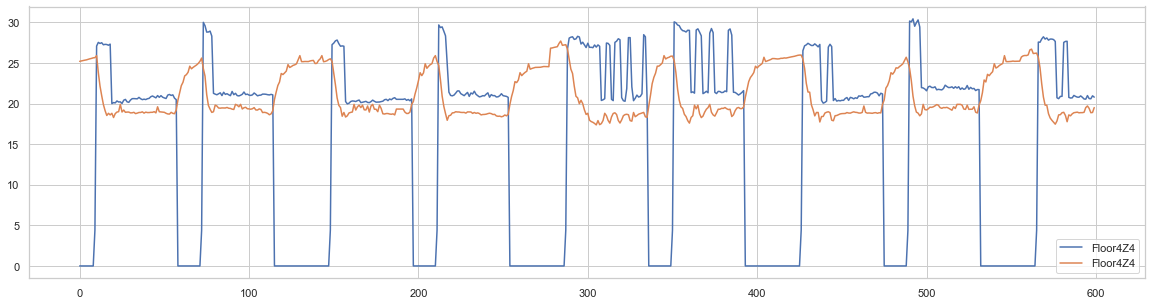

Counter({1: 9869, 2: 4943, 0: 4926})


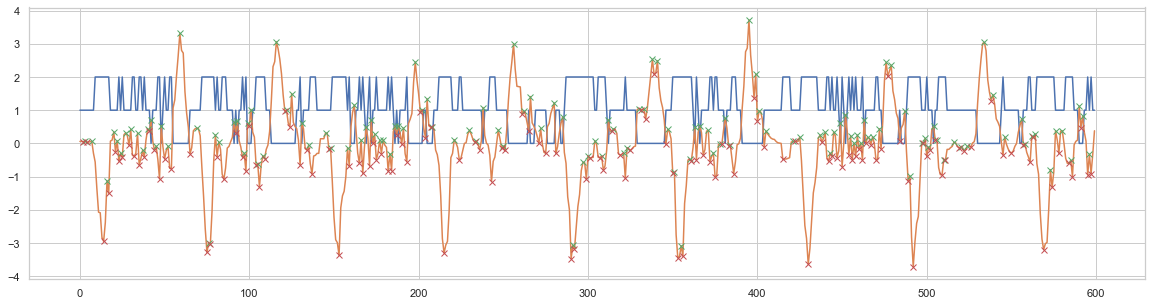

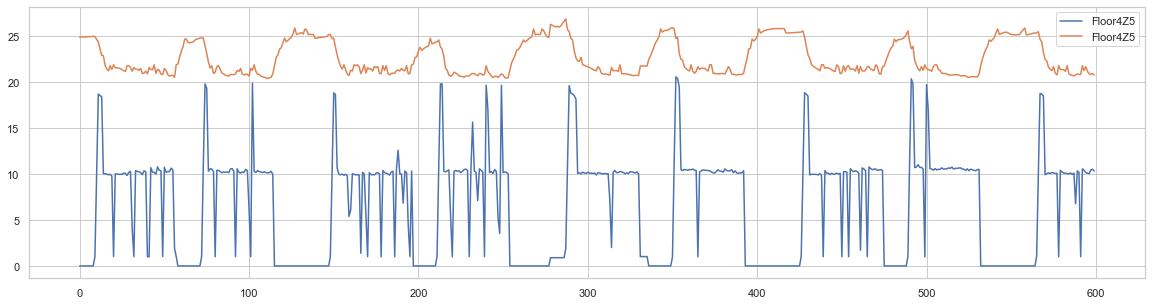

Counter({1: 9842, 2: 4961, 0: 4935})


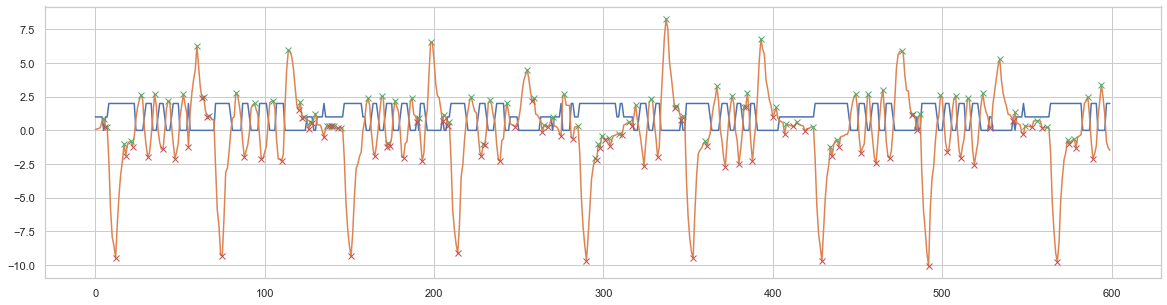

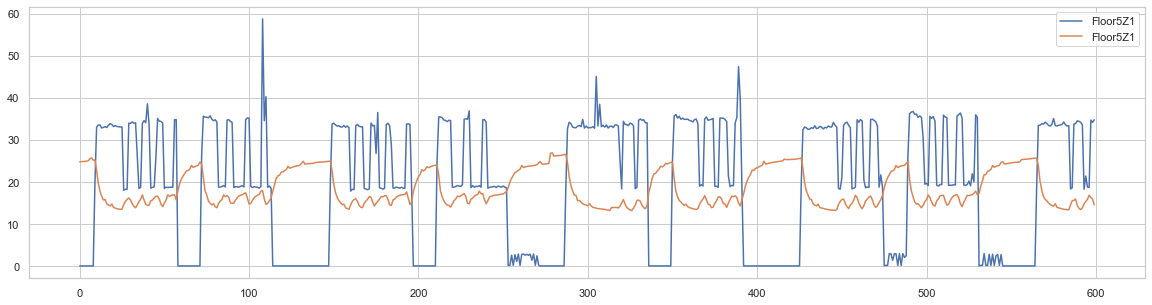

Counter({1: 9818, 2: 4995, 0: 4925})


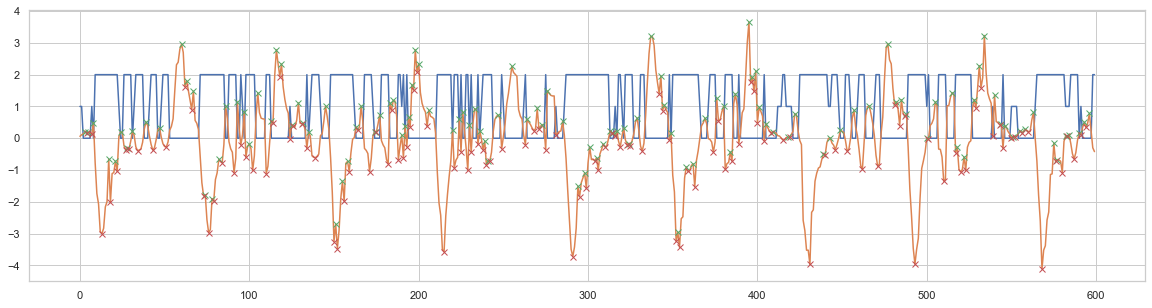

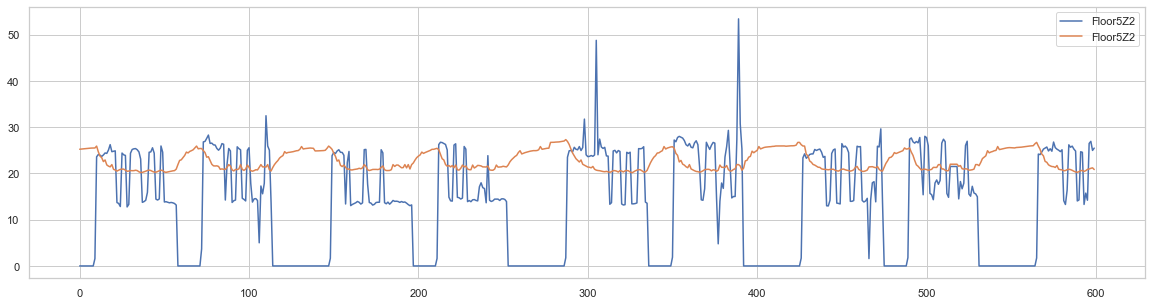

Counter({1: 9869, 2: 4964, 0: 4905})


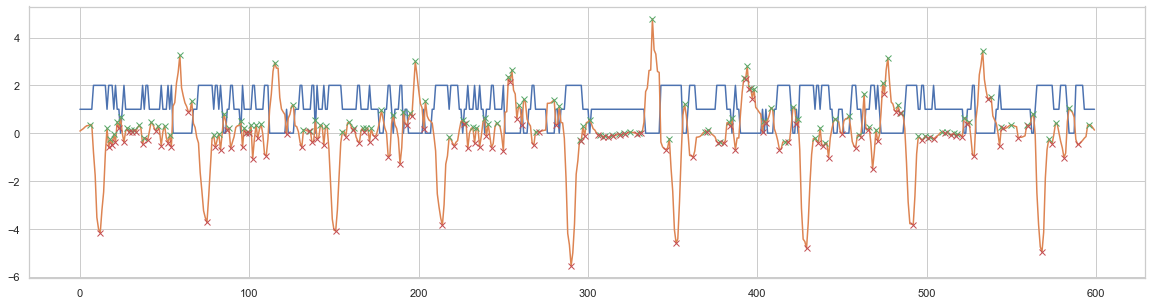

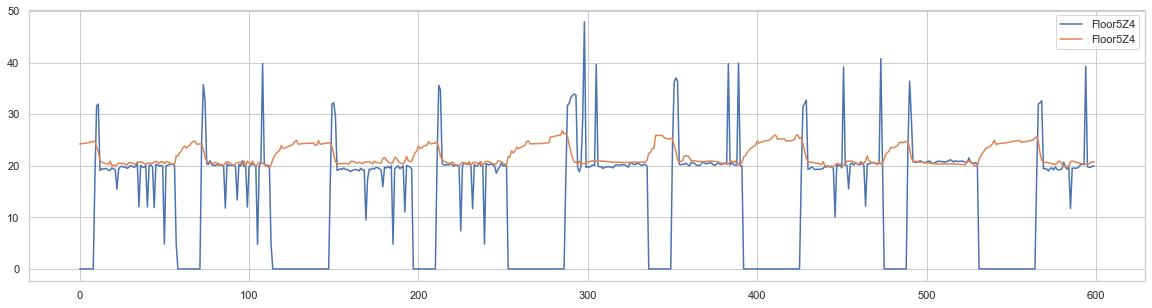

Counter({1: 9913, 2: 4941, 0: 4884})


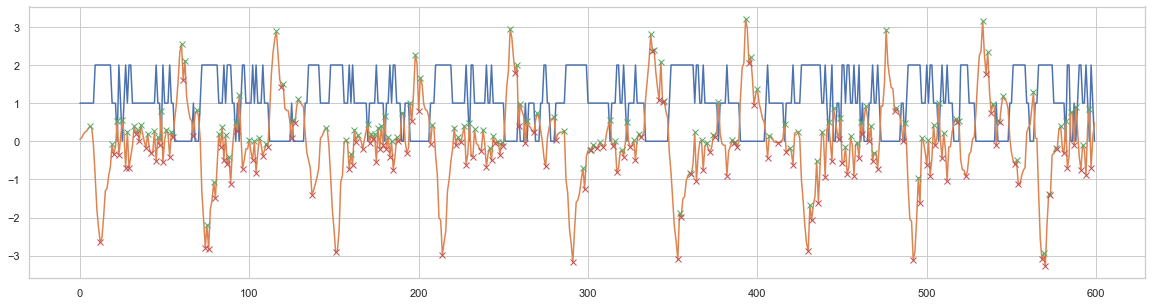

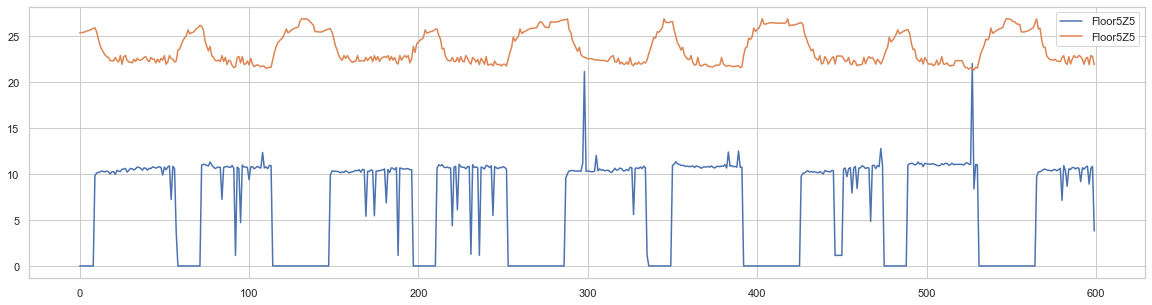

Counter({1: 9884, 2: 4963, 0: 4891})


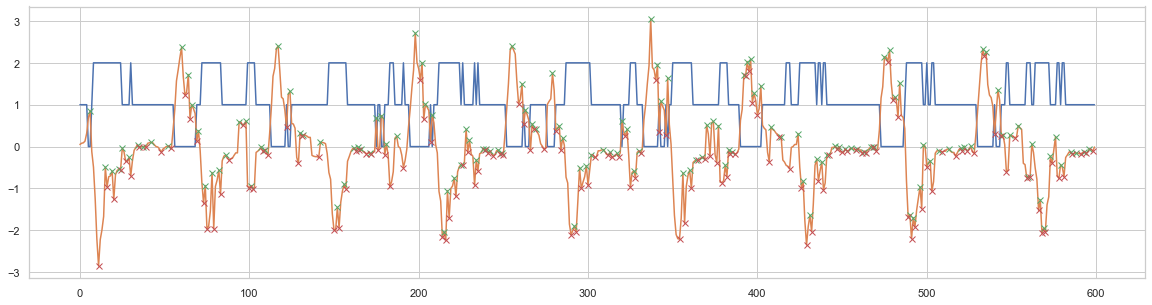

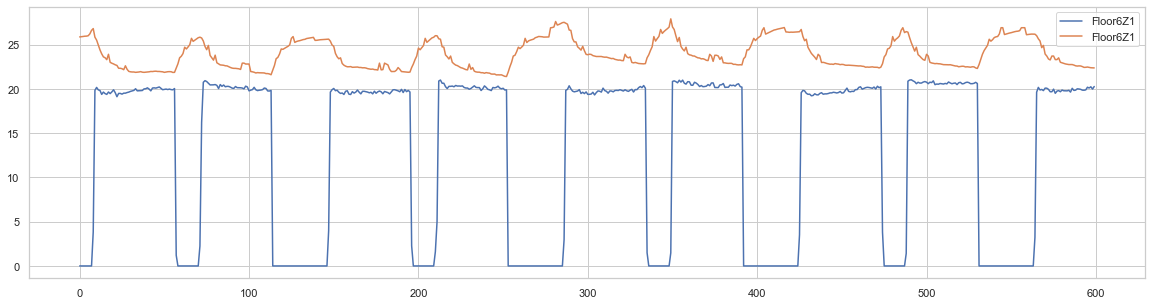

Counter({1: 9895, 2: 4938, 0: 4905})


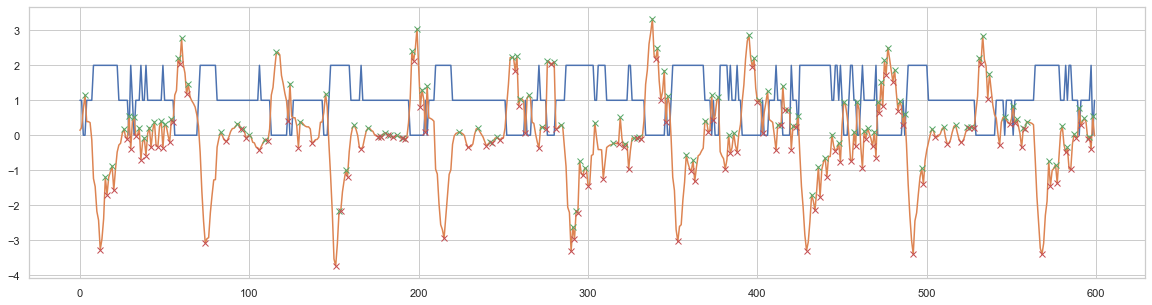

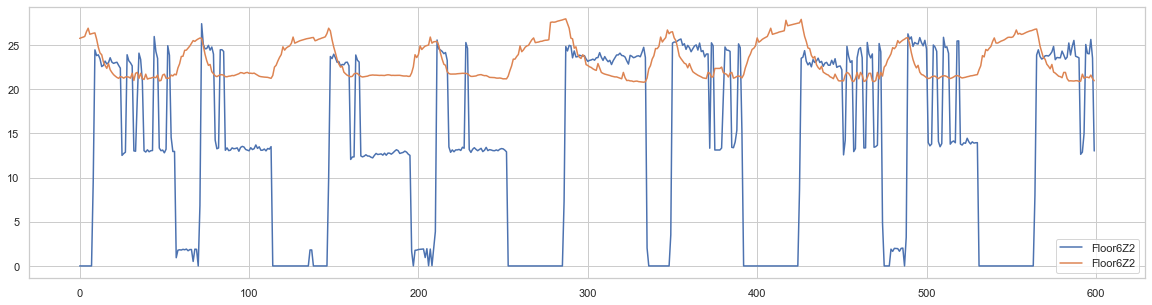

Counter({1: 9864, 2: 4944, 0: 4930})


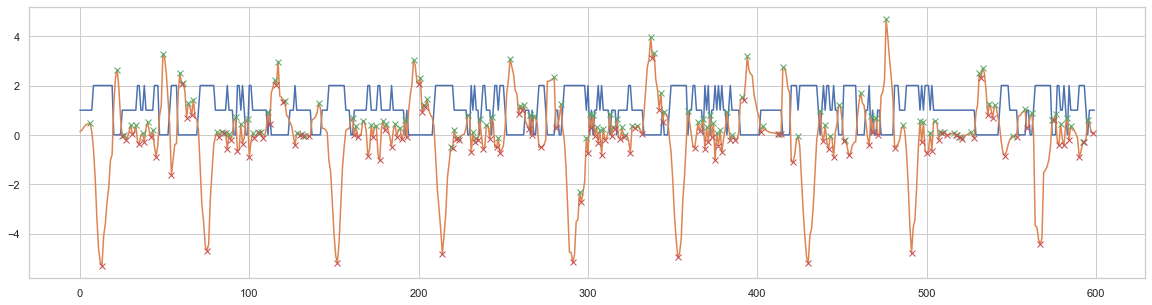

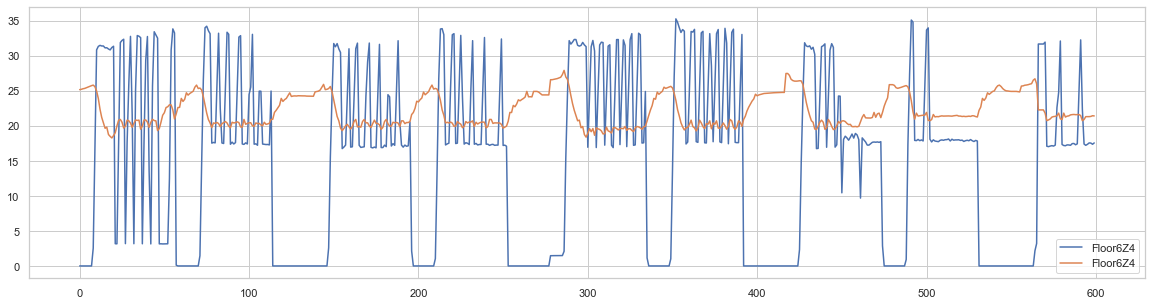

Counter({1: 9861, 2: 4952, 0: 4925})


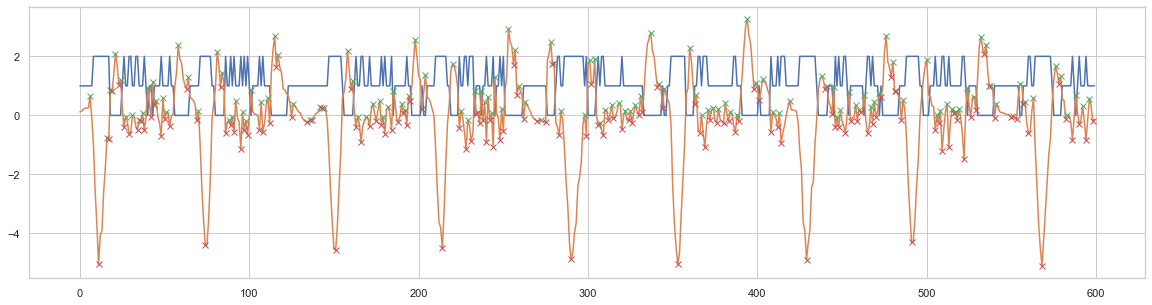

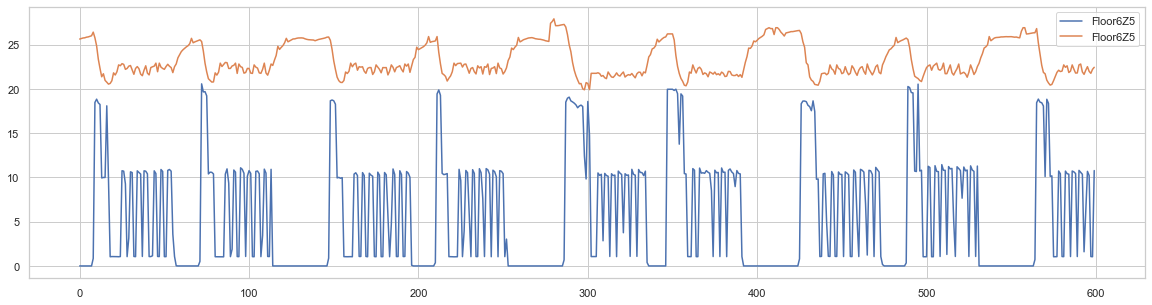

Counter({1: 9872, 2: 4952, 0: 4914})


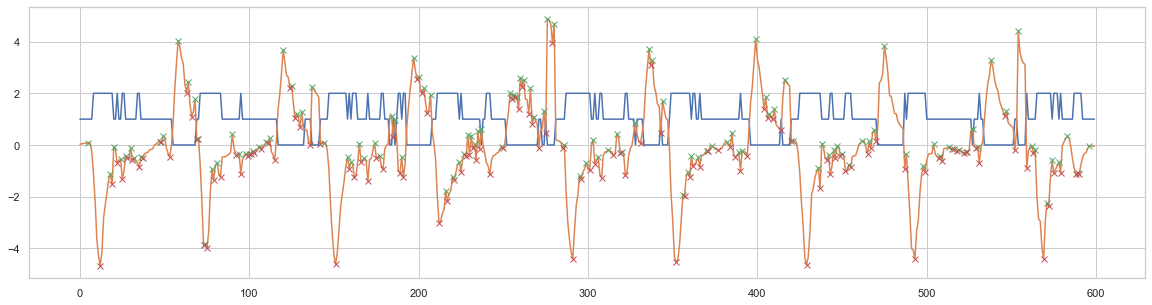

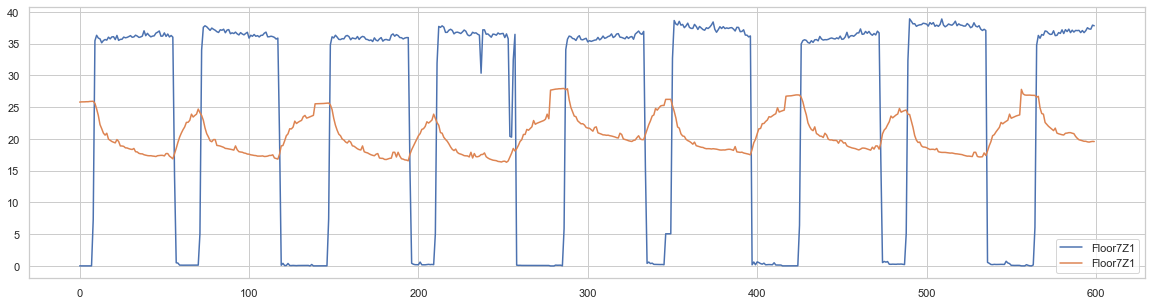

Counter({1: 9875, 2: 4948, 0: 4915})


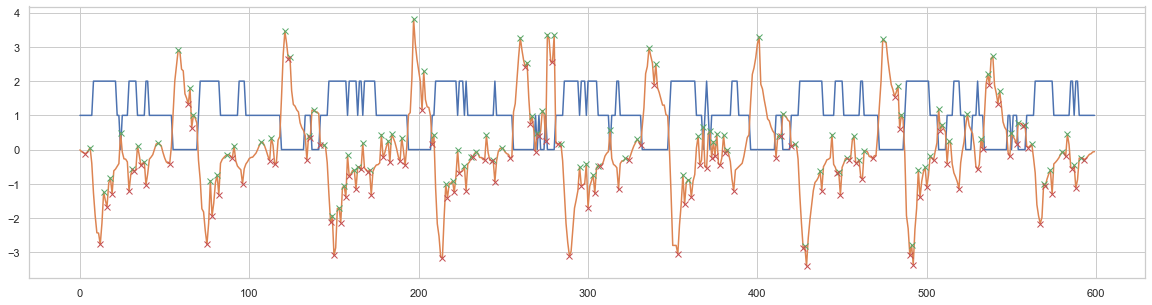

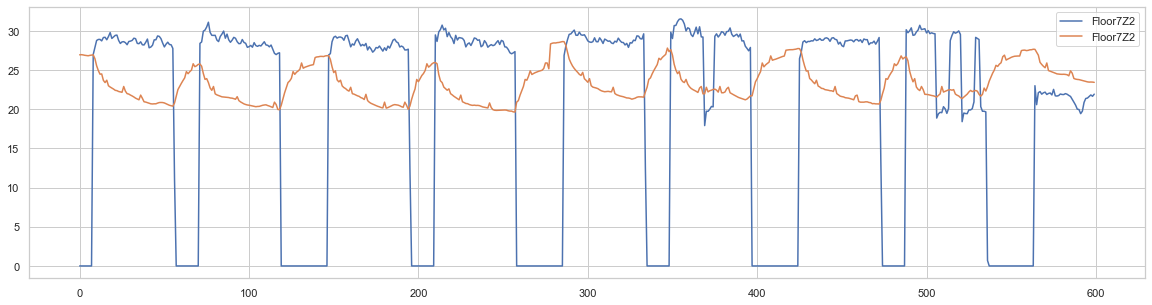

Counter({1: 9865, 2: 4951, 0: 4922})


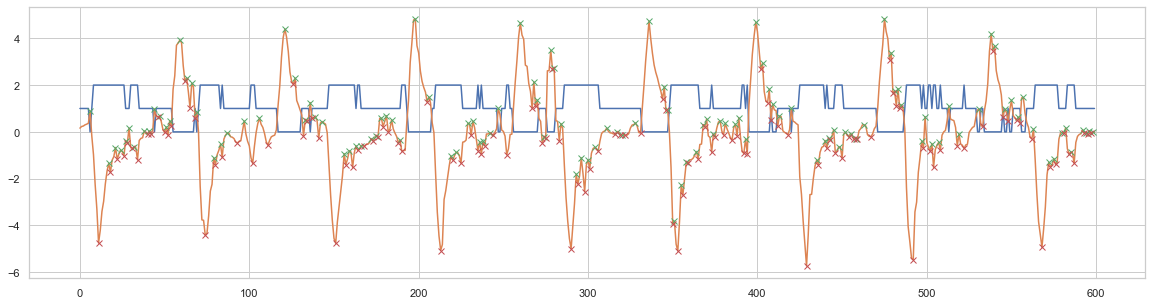

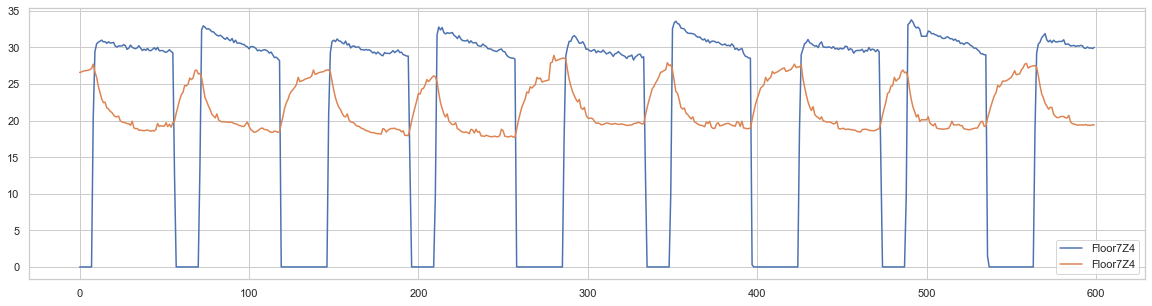

Counter({1: 9878, 2: 4936, 0: 4924})


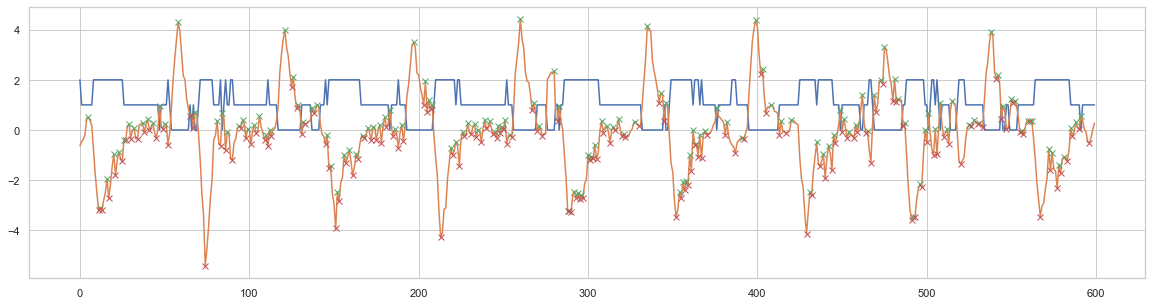

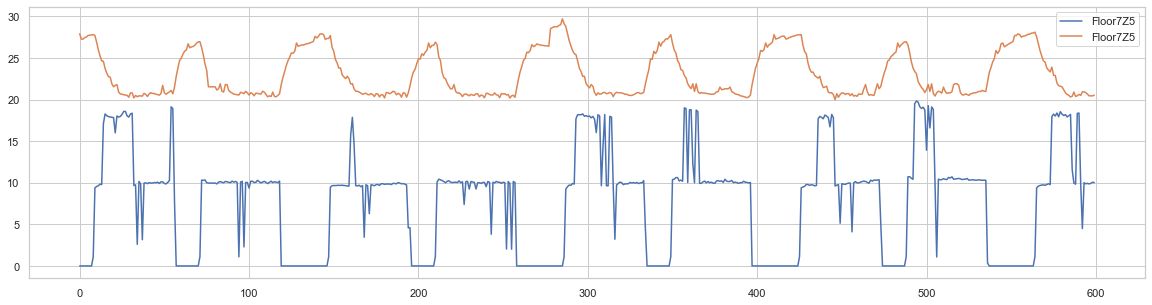

In [343]:
plot_data(resample_wkh,"2019-04-25","ACPower","temperature",0,600)
#plot_data(resample_wkh,"2019-04-25","temperature")

In [31]:
to_distribution_wowk = distribution(resample_wo_wk,cutting_date,*feature)
to_distribution_normal = distribution(resample, cutting_date,*feature)
to_distribution_wkh = distribution(resample_wkh, cutting_date,*feature)

In [32]:
def distance(data, metric):
    wass_dict = {}
    for col1 in data.columns:
        vals = []
        for col2 in data.columns:
            vals.append(metric(data[col1],data[col2]))
        wass_dict[col1] = vals
    return pd.DataFrame(wass_dict, index=data.columns)

In [33]:
hehe = to_distribution_normal.drop(["Floor5Z1","Floor5Z4","Floor7Z1"],axis=1)

In [34]:
wass_dataframe_normal = distance(to_distribution_normal, wasserstein_distance)
wass_dataframe_wowk = distance(to_distribution_wowk, wasserstein_distance)
kl_dataframe_normal = distance(to_distribution_normal, entropy)
kl_dataframe_wowk = distance(to_distribution_wowk, entropy)

<AxesSubplot:>

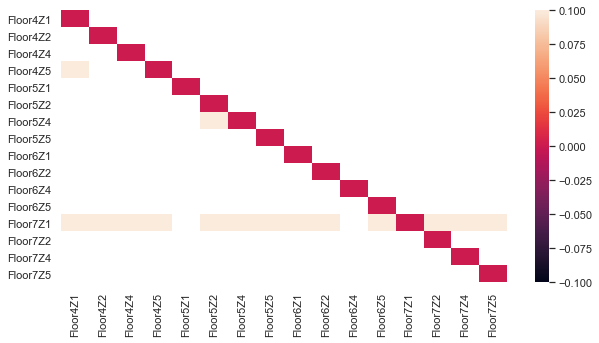

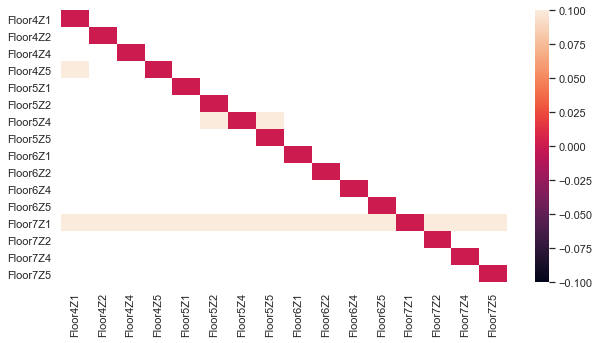

In [35]:
plt.figure(figsize=(10,5))
sns.heatmap(kl_dataframe_normal)
plt.figure(figsize=(10,5))
sns.heatmap(kl_dataframe_wowk)

<AxesSubplot:>

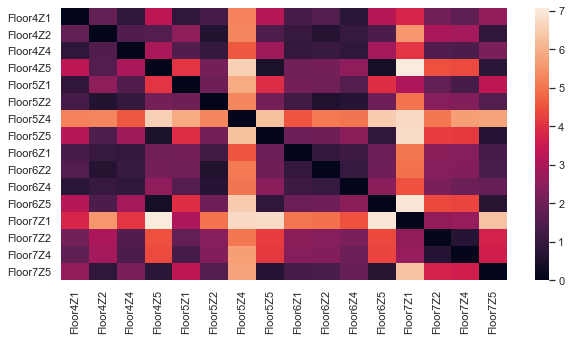

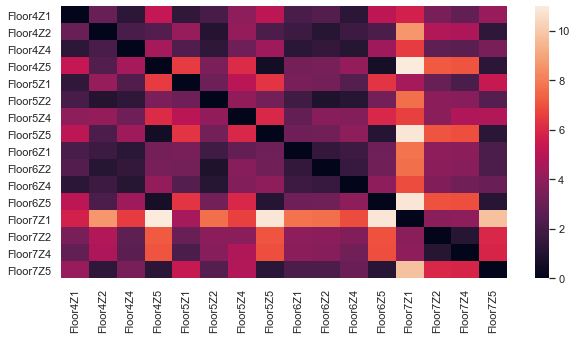

In [36]:
plt.figure(figsize=(10,5))
sns.heatmap(wass_dataframe_normal)
plt.figure(figsize=(10,5))
sns.heatmap(wass_dataframe_wowk)

<AxesSubplot:>

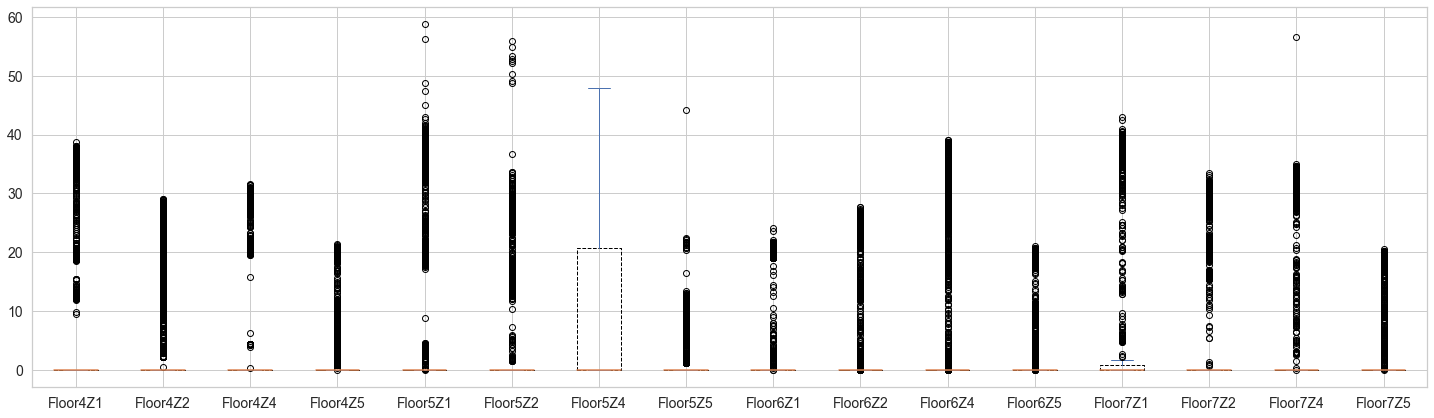

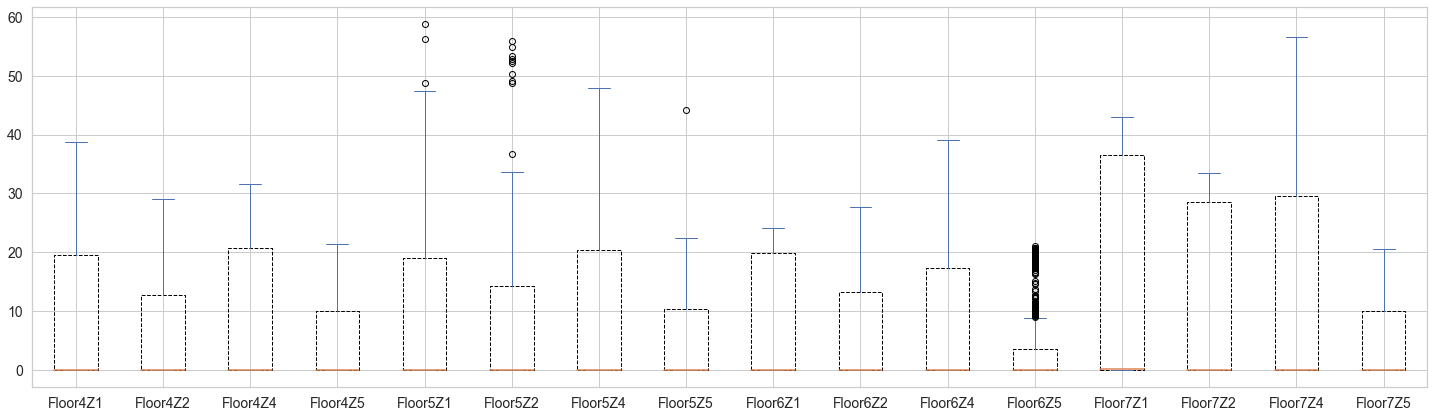

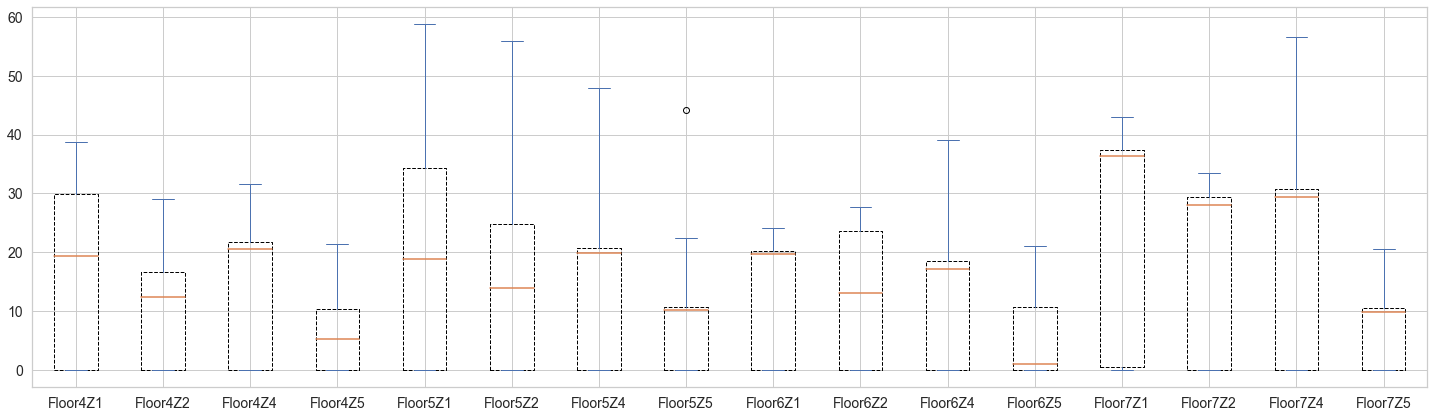

In [37]:
to_distribution_normal.plot(kind="box",
                     figsize=(25,7),
                     grid=True,
                    fontsize=14,
                    #color=dict(medians='r',whiskers='r'),
                    boxprops=dict(linestyle='--', linewidth=1.),
                    medianprops=dict(linestyle='-', linewidth=1.5))

to_distribution_wowk.plot(kind="box",
                     figsize=(25,7),
                     grid=True,
                    fontsize=14,
                    #color=dict(medians='r',whiskers='r'),
                    boxprops=dict(linestyle='--', linewidth=1.),
                    medianprops=dict(linestyle='-', linewidth=1.5))
to_distribution_wkh.plot(kind="box",
                     figsize=(25,7),
                     grid=True,
                    fontsize=14,
                    #color=dict(medians='r',whiskers='r'),
                    boxprops=dict(linestyle='--', linewidth=1.),
                    medianprops=dict(linestyle='-', linewidth=1.5))

In [120]:
resample_wkh

{'Floor4Z5':                      ACPower        date  weekday      time
 Date                                                       
 2019-03-07 07:00:00      0.0  2019-03-07        3  07:00:00
 2019-03-07 07:05:00      0.0  2019-03-07        3  07:05:00
 2019-03-07 07:10:00      0.0  2019-03-07        3  07:10:00
 2019-03-07 07:15:00      0.0  2019-03-07        3  07:15:00
 2019-03-07 07:20:00      0.0  2019-03-07        3  07:20:00
 ...                      ...         ...      ...       ...
 2019-09-27 19:40:00      0.0  2019-09-27        4  19:40:00
 2019-09-27 19:45:00      0.0  2019-09-27        4  19:45:00
 2019-09-27 19:50:00      0.0  2019-09-27        4  19:50:00
 2019-09-27 19:55:00      0.0  2019-09-27        4  19:55:00
 2019-09-27 20:00:00      0.0  2019-09-27        4  20:00:00
 
 [22294 rows x 4 columns],
 'Floor4Z4':                      ACPower        date  weekday      time
 Date                                                       
 2019-03-07 07:00:00      0.0  2

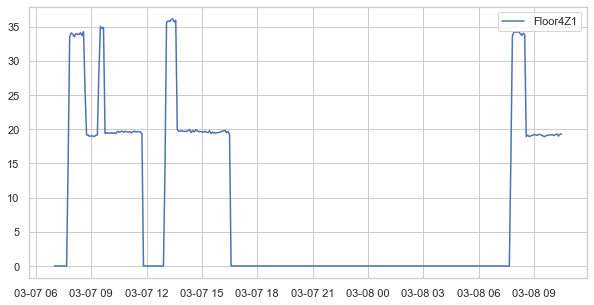

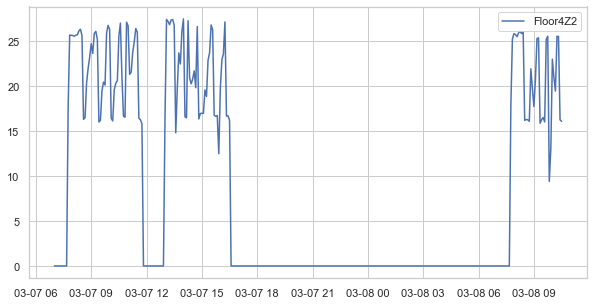

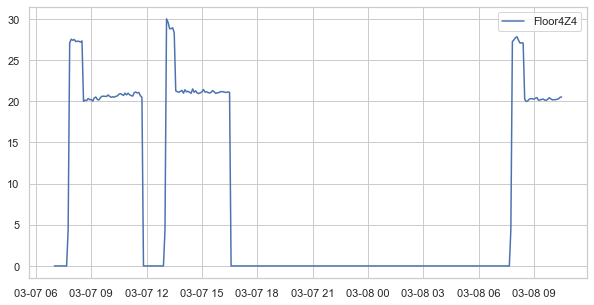

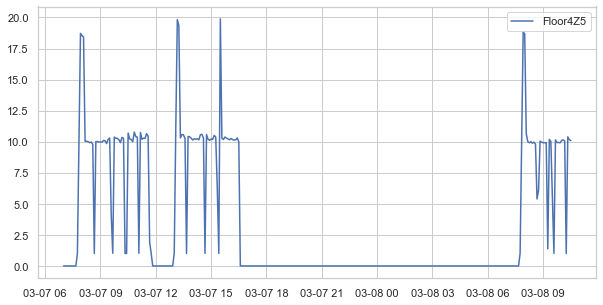

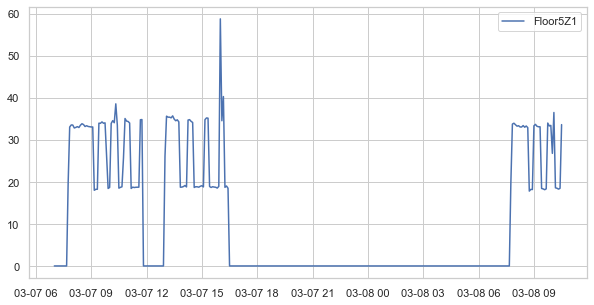

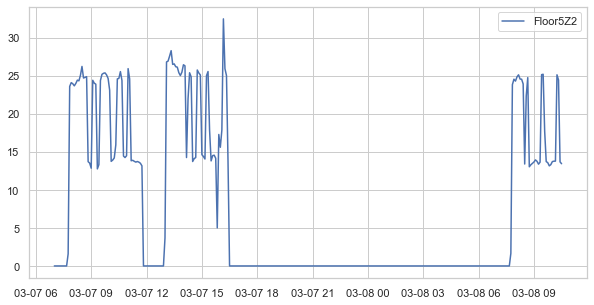

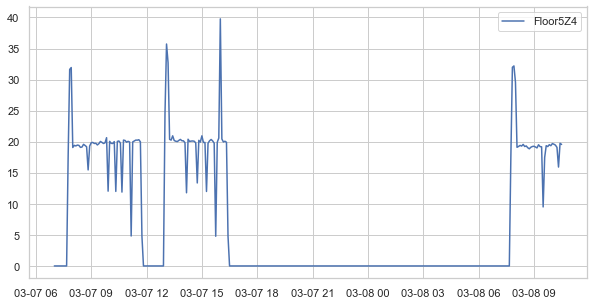

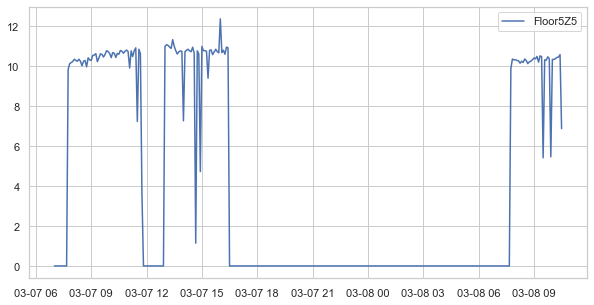

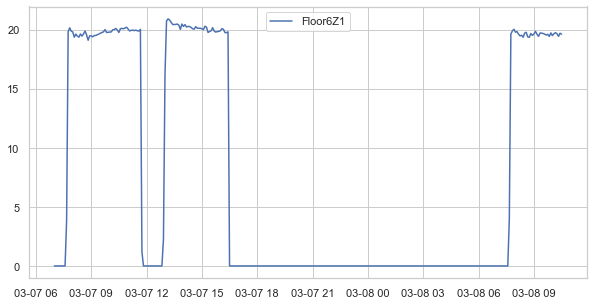

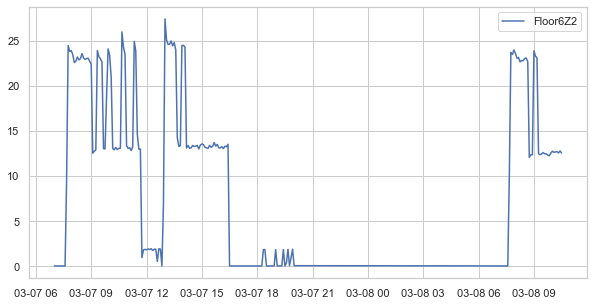

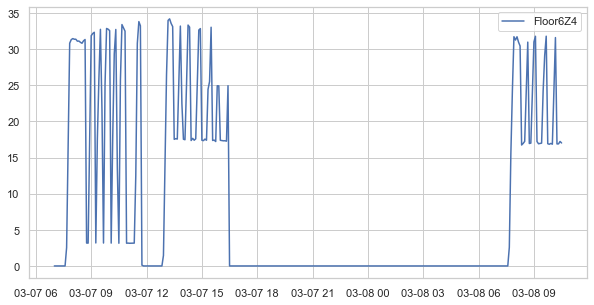

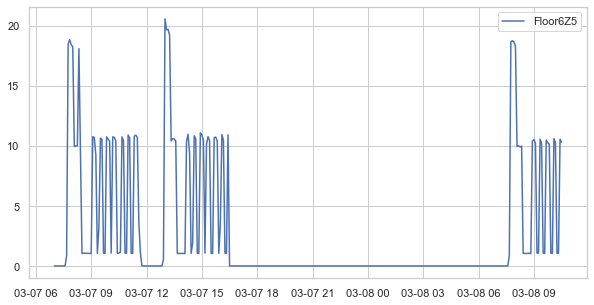

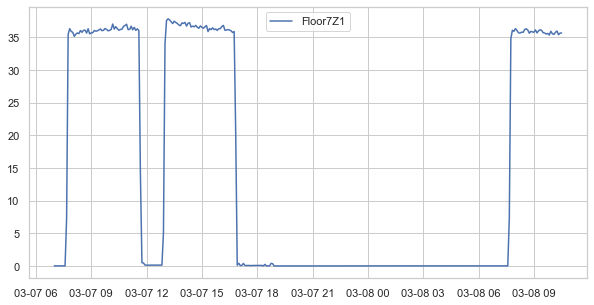

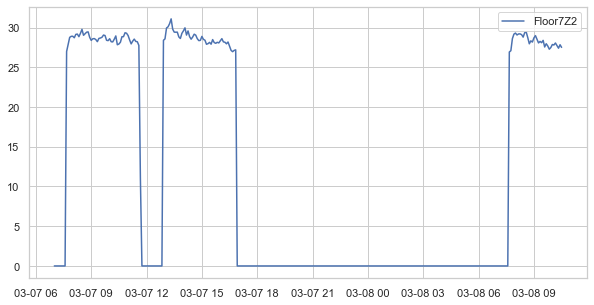

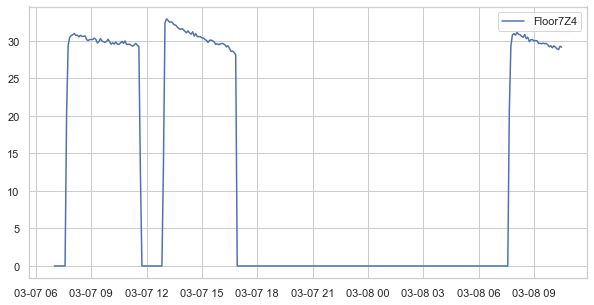

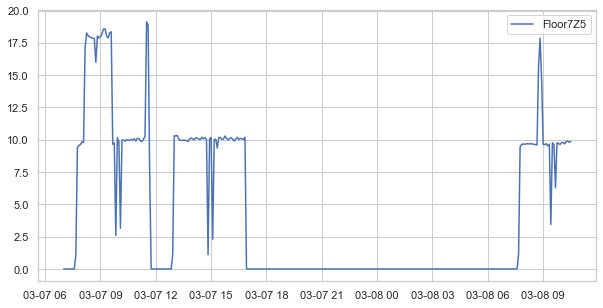

In [134]:
for col in to_distribution_normal.columns:
    plt.figure(figsize=(10,5))
    plt.plot(to_distribution_wkh[col][:200],label=col)
    plt.legend()

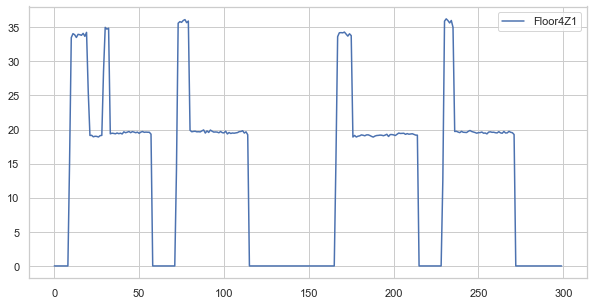

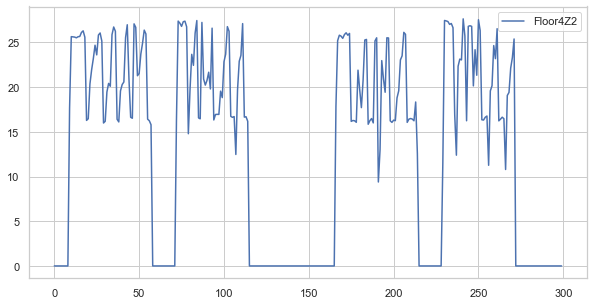

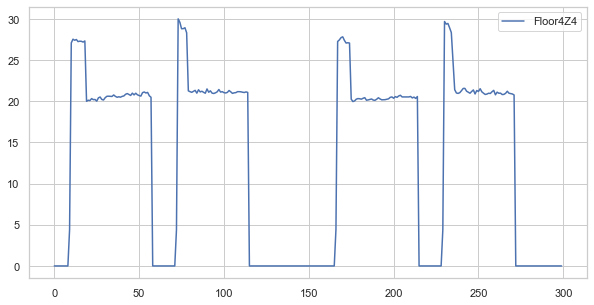

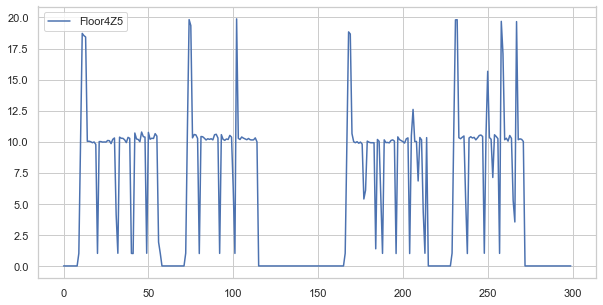

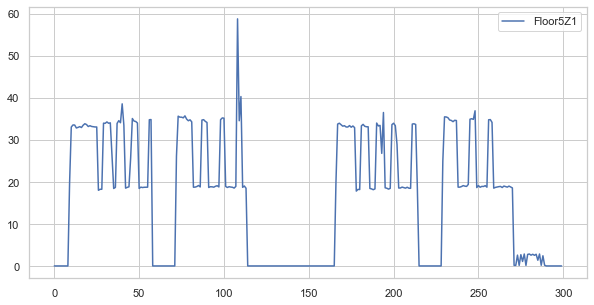

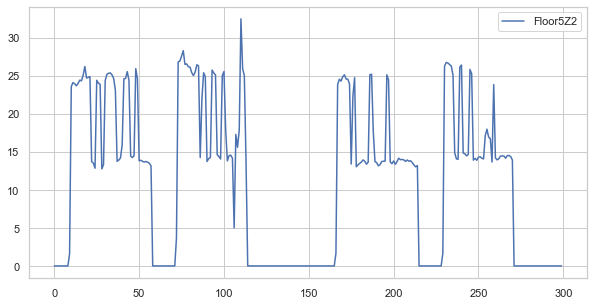

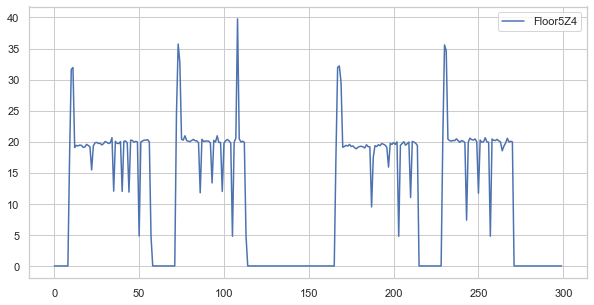

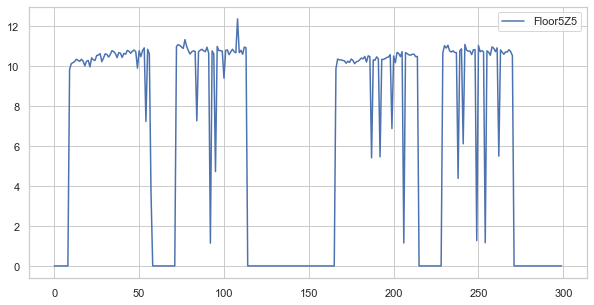

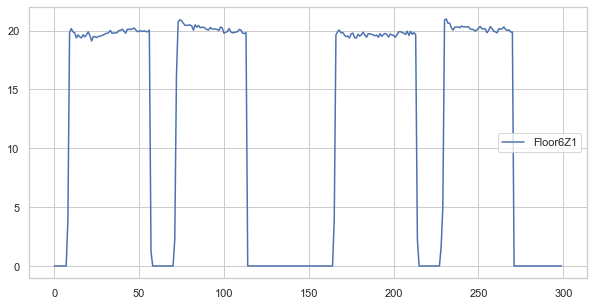

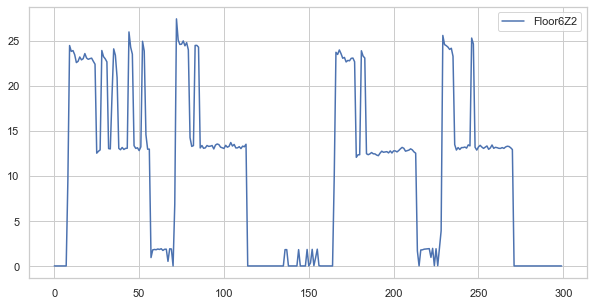

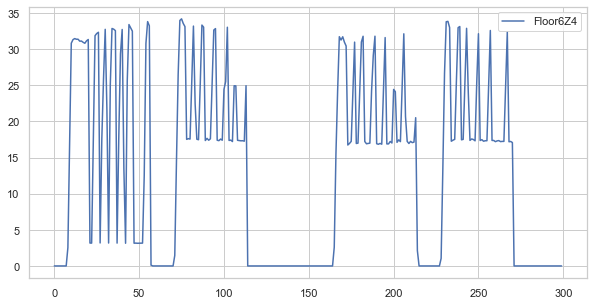

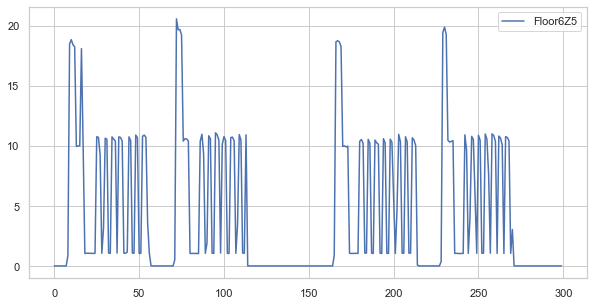

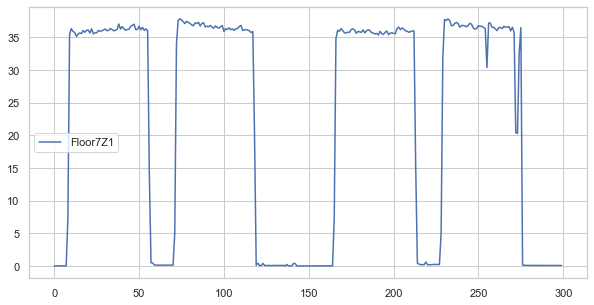

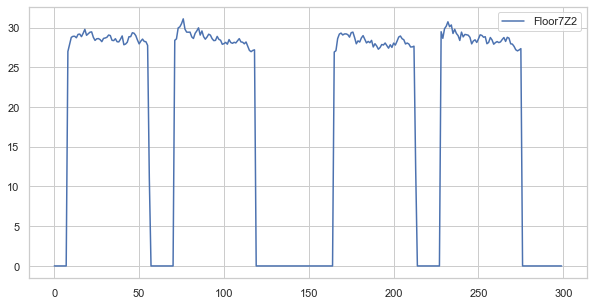

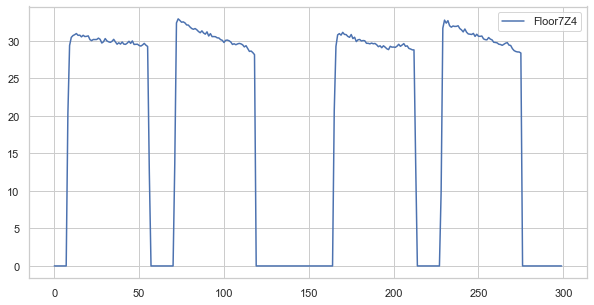

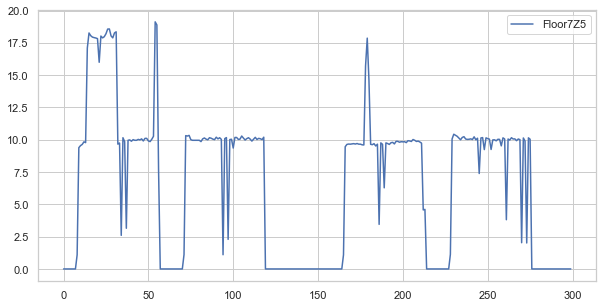

In [119]:
for col in to_distribution_wkh.columns:
    plt.figure(figsize=(10,5))
    plt.plot(to_distribution_wkh[col][:300].values,label=col)
    plt.legend()